In [1617]:
import math
import numpy as np
import os

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
sns.set_style("ticks")
sns.set_context("paper")
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [1618]:
three_d_points = np.array([
    [-0.08, -2.30333333, 1.19666667],  # Top right solar panel
    [-0.15666667, -0.84333333, 1.19666667],  # Top left solar panel
    [-0.08, -2.30333333, -0.78333333],  # Bottom right solar panel
    [-0.15666667, -0.84333333, -0.78333333],  # Bottom left solar panel
    [-0.24333333, 1.03, -0.65333333],  # Bottom left satellite
])

three_d_points_names = [
    'Top right solar panel',
    'Top left solar panel',
    'Bottom right solar panel',
    'Bottom left solar panel',
    'Bottom left satellite'
]


def get_normalized_rotation(roll, pitch, yaw):
    roll_rotation_axis = -19.4321
    pitch_rotation_axis = 0
    yaw_rotation_axis = 179.9654
    r_roll_rotation_axis = np.array([[1, 0, 0],
                                     [0, math.cos(roll_rotation_axis / 180 * math.pi),
                                      -math.sin(roll_rotation_axis / 180 * math.pi)],
                                     [0, math.sin(roll_rotation_axis / 180 * math.pi),
                                      math.cos(roll_rotation_axis / 180 * math.pi)]])

    r_pitch_rotation_axis = np.array(
        [[math.cos(pitch_rotation_axis / 180 * math.pi), 0, math.sin(pitch_rotation_axis / 180 * math.pi)],
         [0, 1, 0],
         [-math.sin(pitch_rotation_axis / 180 * math.pi), 0, math.cos(pitch_rotation_axis / 180 * math.pi)]])

    r_yaw_rotation_axis = np.array(
        [[math.cos(yaw_rotation_axis / 180 * math.pi), -math.sin(yaw_rotation_axis / 180 * math.pi), 0],
         [math.sin(yaw_rotation_axis / 180 * math.pi), math.cos(yaw_rotation_axis / 180 * math.pi), 0],
         [0, 0, 1]])

    rotation_matrix_rotation_axis = r_yaw_rotation_axis @ r_pitch_rotation_axis @ r_roll_rotation_axis

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = (r_yaw @ r_pitch @ r_roll)

    roll = np.rad2deg(math.atan2(rotation_matrix[2, 1], rotation_matrix[2, 2]))
    pitch = np.rad2deg(
        math.atan2(-rotation_matrix[2, 0],
                   math.sqrt(rotation_matrix[2, 1] ** 2 + rotation_matrix[2, 2] ** 2)))
    yaw = np.rad2deg(
        math.atan2(rotation_matrix[1, 0], rotation_matrix[0, 0]))

    return roll, pitch, yaw


def get_rotated_point(roll, pitch, yaw, point=None):
    if point is None:
        point = [-0.08, -2.30333333, 1.19666667]

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = r_yaw @ r_pitch @ r_roll

    rotated_3d_points = np.dot(rotation_matrix, point)

    return rotated_3d_points

In [1619]:
folder = "../test_images/dynamic_unknowndeg_0to360_5degstep/"
suffix = '_eps2_final'
colors = ['red', 'green', 'blue']
normalize = True

In [1620]:
df_true = pd.read_csv(folder + "real_scores.csv")
df_true = df_true.rename(columns={'correct_roll': 'roll', 'correct_pitch': 'pitch', 'correct_yaw':
    'yaw'})
if normalize:
    df_true['roll'], df_true['pitch'], df_true['yaw'] = np.vectorize(get_normalized_rotation)(df_true['roll'],
                                                                                              df_true['pitch'],
                                                                                              df_true['yaw'])
df_true['img_number'] = df_true.index
# drop first image
df_true = df_true.drop(df_true.index[0])

In [1621]:
df_guess = pd.read_csv(folder + "guesses" + suffix + ".csv")
# drop first image
df_guess = df_guess.drop(df_guess.index[0])
if normalize:
    df_guess['roll'], df_guess['pitch'], df_guess['yaw'] = np.vectorize(get_normalized_rotation)(df_guess['roll'],
                                                                                                 df_guess['pitch'],
                                                                                                 df_guess['yaw'])
    df_guess['roll_min'], df_guess['pitch_min'], df_guess['yaw_min'] = np.vectorize(get_normalized_rotation)(
        df_guess['roll_min'],
        df_guess['pitch_min'],
        df_guess['yaw_min'])
    df_guess['roll_max'], df_guess['pitch_max'], df_guess['yaw_max'] = np.vectorize(get_normalized_rotation)(
        df_guess['roll_max'],
        df_guess['pitch_max'],
        df_guess['yaw_max'])

In [1622]:
df = pd.read_csv(folder + "fine_scores" + suffix + ".csv")
# drop first image
df = df.drop(df.index[0])
if normalize:
    df['roll'], df['pitch'], df['yaw'] = np.vectorize(get_normalized_rotation)(df['roll'],
                                                                               df['pitch'],
                                                                               df['yaw'])

In [1623]:
df_rough = pd.read_csv(folder + "best_scores.csv")
# drop first image
df_rough = df_rough.drop(df_rough.index[0])
df_rough['img_number'] = df_rough['file_name']
if normalize:
    df_rough['roll'], df_rough['pitch'], df_rough['yaw'] = np.vectorize(get_normalized_rotation)(df_rough['roll'],
                                                                                                 df_rough['pitch'],
                                                                                                 df_rough['yaw'])

In [1649]:
df_guess


,img_number,roll,pitch,yaw,x,y,z,roll_min,roll_max,pitch_min,pitch_max,yaw_min,yaw_max,x_min,x_max,y_min,y_max,z_min,z_max
1,1,161.323237,-63.821895,-74.940878,0.209125,0.073098,-0.448884,153.323237,169.323237,-59.821895,-67.821895,-78.940878,-70.940878,0.009125,0.409125,-0.126902,0.273098,-0.648884,-0.248884
2,2,161.323237,-63.821895,-74.940878,0.209125,0.073098,-0.448884,129.323237,-166.676763,-47.821895,-79.821895,-90.940878,-58.940878,-0.590875,1.009125,-0.726902,0.873098,-1.248884,0.351116
3,3,160.791913,-64.480790,-85.073014,0.212961,0.141970,-0.573226,152.791913,168.791913,-60.480790,-68.480790,-89.073014,-81.073014,0.012961,0.412961,-0.058030,0.341970,-0.773226,-0.373226
4,4,156.693224,-64.454345,-86.003883,0.223667,0.145339,-0.570210,148.693224,164.693224,-60.454345,-68.454345,-90.003883,-82.003883,0.023667,0.423667,-0.054661,0.345339,-0.770210,-0.370210
5,5,153.322464,-65.666543,-87.711684,0.247597,0.157995,-0.446797,145.322464,161.322464,-61.666543,-69.666543,-91.711684,-83.711684,0.047597,0.447597,-0.042005,0.357995,-0.646797,-0.246797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,166.147587,-69.491032,-54.252925,0.232669,0.043291,0.099541,155.745184,176.549990,-68.183181,-70.798882,-64.868004,-43.637846,0.223961,0.241377,0.032068,0.054514,-0.003082,0.202164
140,140,168.665418,-68.654994,-61.977937,0.228239,0.060772,0.022778,158.935122,178.395714,-67.384527,-69.925461,-71.952240,-52.003634,0.218900,0.237578,0.048791,0.072753,-0.057598,0.103155
141,141,168.995516,-67.561338,-67.412368,0.221871,0.073592,-0.077526,161.902413,176.088618,-66.292590,-68.830085,-74.721074,-60.103661,0.211077,0.232664,0.061592,0.085591,-0.160032,0.004979
142,142,167.102466,-65.945446,-70.462906,0.212406,0.075760,-0.197197,161.020736,173.184195,-64.674173,-67.216720,-76.739665,-64.186147,0.200139,0.224673,0.063220,0.088300,-0.276569,-0.117825


In [1651]:
def plot_guess(guess_type, df=df_guess):
    sns.lineplot(data=df, x='img_number', y=guess_type, color='blue', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_min', color='red', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_max', color='green', ci=None)
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='black')
    plt.legend(['Guess', 'Min', 'Max', 'Lowest loss estimate'])
    plt.title('SMA ' + guess_type + ' guesses')
    plt.xlabel('Image number')
    plt.ylabel(guess_type + ' (deg)')
    plt.savefig(folder + guess_type + '_guesses' + suffix + '.png')
    plt.show()

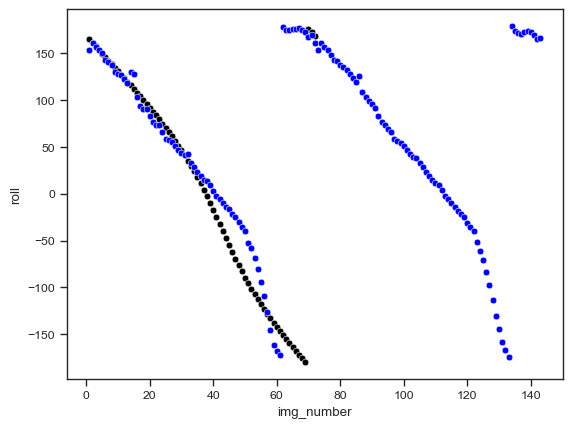

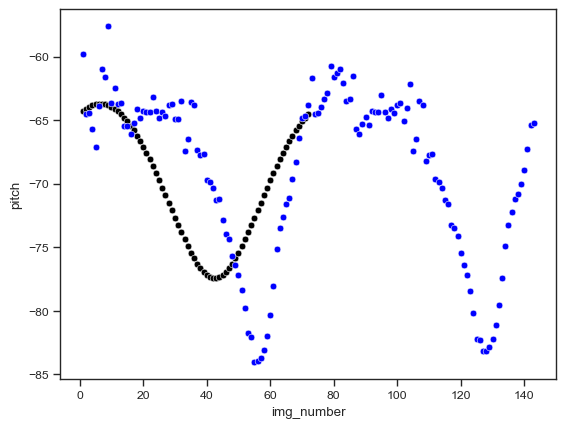

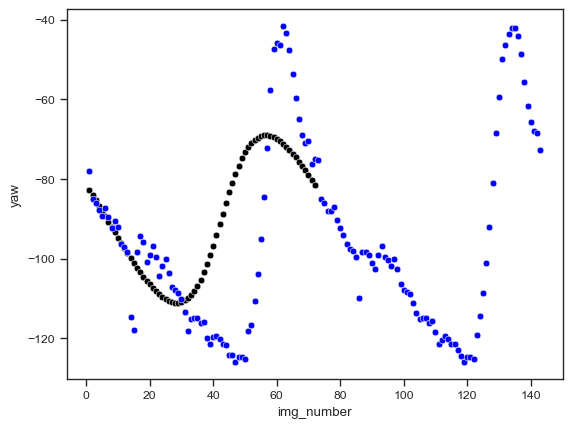

In [1652]:
for guess_type in ['roll', 'pitch', 'yaw']:
    sns.scatterplot(data=df_true, x='img_number', y=guess_type, color='black')
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='blue')
    # sns.scatterplot(data=df_rough, x='img_number', y=guess_type, color='green')
    plt.show()

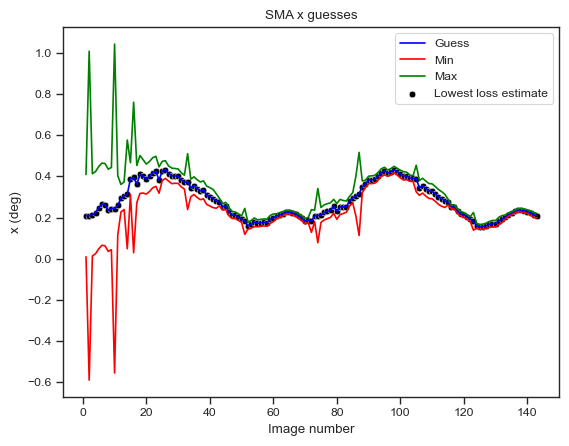

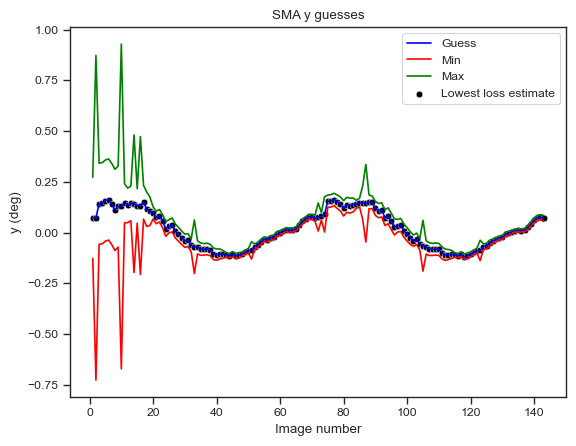

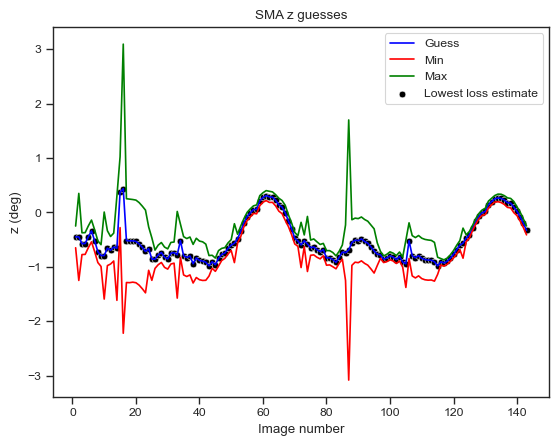

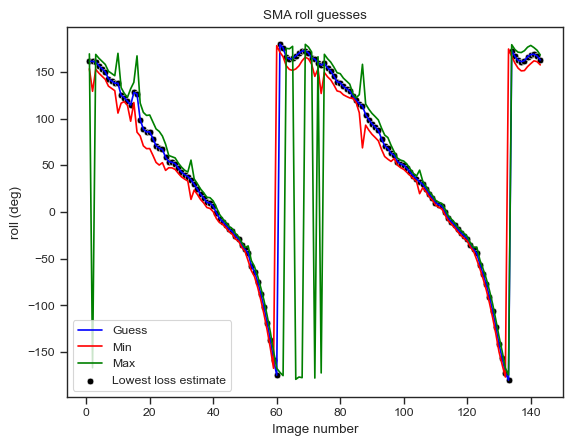

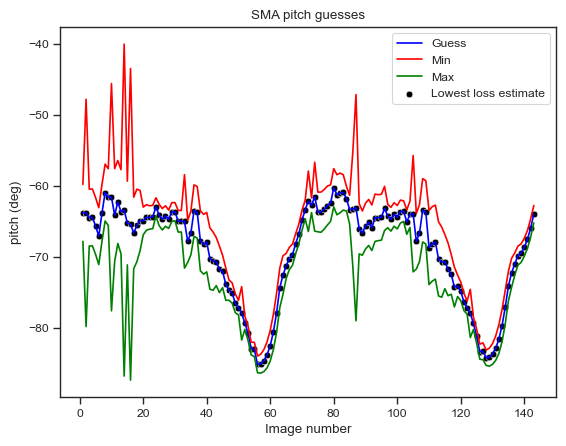

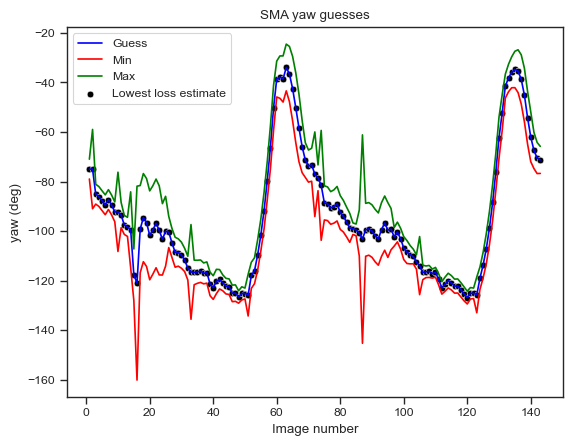

In [1653]:
for guess_type in ['x', 'y', 'z', 'roll', 'pitch', 'yaw']:
    plot_guess(guess_type)

In [1627]:
df_rotated_points_true = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df_true.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df_true['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points_true = pd.concat([df_local, df_rotated_points_true])

In [1628]:
df_rotated_points_true = df_rotated_points_true.merge(df_true, on='img_number')

In [1654]:
df_rotated_points = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points = pd.concat([df_local, df_rotated_points])
df_rotated_points.to_csv(folder + 'rotated_points.csv')

In [1630]:
df_rotated_points = df_rotated_points.merge(df, on='img_number')

In [1631]:
df_rotated_points_rough = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df_rough.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df_rough['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points_rough = pd.concat([df_local, df_rotated_points_rough])

In [1632]:
df_rotated_points_rough = df_rotated_points_rough.merge(df_rough, on='img_number')

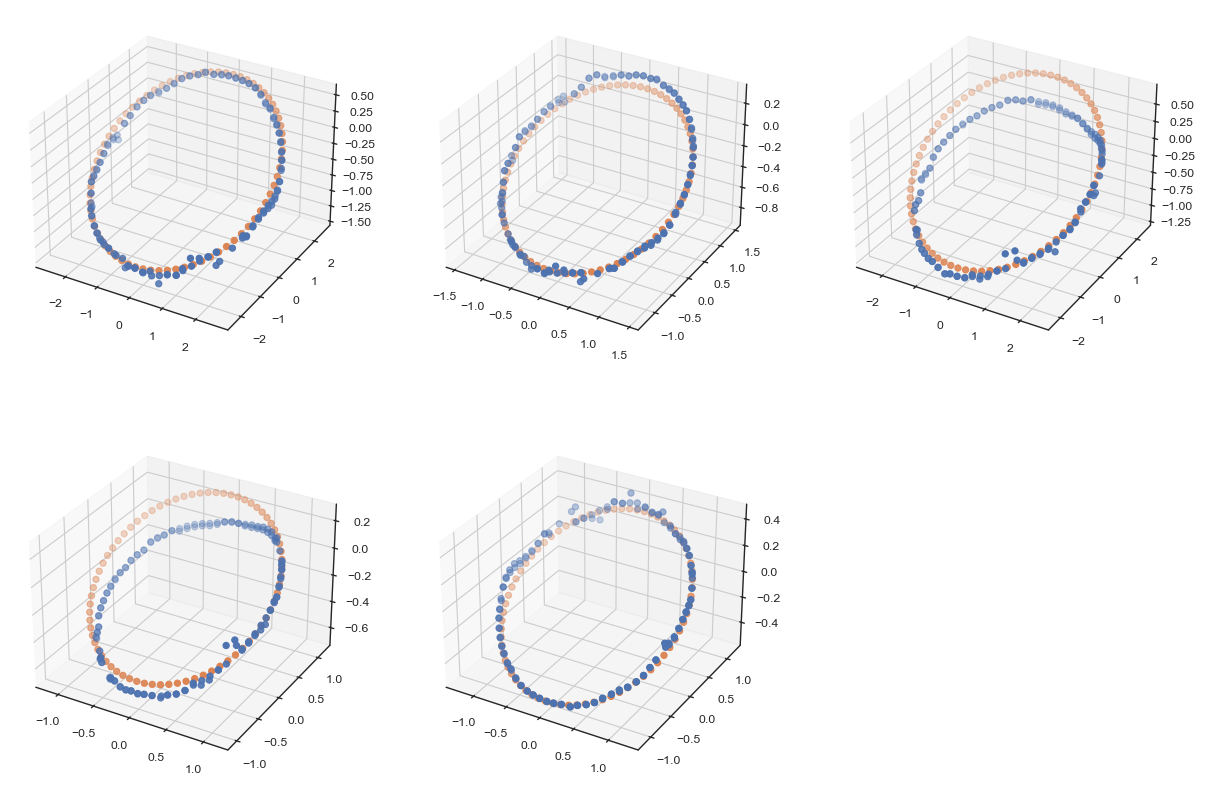

In [1633]:
# 3d subplots
fig = plt.figure(figsize=(15, 10))
for i, point in enumerate(three_d_points):
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.scatter(df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['x_point'],
               df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['y_point'],
               df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['z_point'],
               label=three_d_points_names[i])
    ax.scatter(df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['x_point'],
               df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['y_point'],
               df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['z_point'],
               label=three_d_points_names[i] + ' true')

In [1634]:
df_rotated_points_all = df_rotated_points.merge(df_rotated_points_true, on=['img_number', '3d_point'],
                                                suffixes=('_fine', '_true'))

In [1635]:
df_rotated_points_all

,x_point_fine,y_point_fine,z_point_fine,img_number,3d_point,iterations,loss,roll_fine,pitch_fine,yaw_fine,x,y,z,x_point_true,y_point_true,z_point_true,roll_true,pitch_true,yaw_true
0,-0.828697,0.872144,0.315567,1,Bottom left satellite,812,8.861239e+02,153.323237,-59.821895,-77.876194,0.409125,0.216384,-0.248884,-0.932807,0.804792,0.170695,164.863986,-64.310508,-82.743138
1,1.005714,0.580711,0.026096,1,Bottom left solar panel,812,8.861239e+02,153.323237,-59.821895,-77.876194,0.409125,0.216384,-0.248884,0.940867,0.675149,0.091152,164.863986,-64.310508,-82.743138
2,2.408307,0.263027,-0.237129,1,Bottom right solar panel,812,8.861239e+02,153.323237,-59.821895,-77.876194,0.409125,0.216384,-0.248884,2.386522,0.479418,-0.005017,164.863986,-64.310508,-82.743138
3,0.457828,-1.101321,-0.863280,1,Top left solar panel,812,8.861239e+02,153.323237,-59.821895,-77.876194,0.409125,0.216384,-0.248884,0.645577,-1.098751,-0.737390,164.863986,-64.310508,-82.743138
4,1.860421,-1.419004,-1.126506,1,Top right solar panel,812,8.861239e+02,153.323237,-59.821895,-77.876194,0.409125,0.216384,-0.248884,2.091232,-1.294483,-0.833559,164.863986,-64.310508,-82.743138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.989330,0.726709,0.200189,72,Bottom left satellite,476,1.094025e-08,161.322770,-63.821884,-74.940424,0.209128,0.073097,-0.448869,-1.000353,0.725199,0.142602,168.680000,-64.540000,-81.470000
356,0.885701,0.748548,0.067639,72,Bottom left solar panel,476,1.094025e-08,161.322770,-63.821884,-74.940424,0.209128,0.073097,-0.448869,0.879153,0.750088,0.117576,168.680000,-64.540000,-81.470000
357,2.339120,0.670075,-0.069822,72,Bottom right solar panel,476,1.094025e-08,161.322770,-63.821884,-74.940424,0.209128,0.073097,-0.448869,2.338183,0.673953,0.063602,168.680000,-64.540000,-81.470000
358,0.710778,-1.041715,-0.759863,72,Top left solar panel,476,1.094025e-08,161.322770,-63.821884,-74.940424,0.209128,0.073097,-0.448869,0.754809,-1.041104,-0.717030,168.680000,-64.540000,-81.470000


In [1636]:
# df_rotated_points_all['residual_roll'] = df_rotated_points_all['roll_fine'] - df_rotated_points_all['roll_true']
# signed delta angle
df_rotated_points_all['residual_roll'] = np.vectorize(min)(
    df_rotated_points_all['roll_fine'] - df_rotated_points_all['roll_true'],
    (df_rotated_points_all['roll_true'] + 360) -
    df_rotated_points_all['roll_fine'])
df_rotated_points_all['residual_pitch'] = np.vectorize(min)(
    df_rotated_points_all['pitch_fine'] - df_rotated_points_all['pitch_true'],
    (df_rotated_points_all['pitch_true'] + 360) -
    df_rotated_points_all['pitch_fine'])
df_rotated_points_all['residual_yaw'] = np.vectorize(min)(
    df_rotated_points_all['yaw_fine'] - df_rotated_points_all['yaw_true'],
    (df_rotated_points_all['yaw_true'] + 360) -
    df_rotated_points_all['yaw_fine'])
df_rotated_points_all['residual_x'] = df_rotated_points_all['x_point_fine'] - df_rotated_points_all['x_point_true']
df_rotated_points_all['residual_y'] = df_rotated_points_all['y_point_fine'] - df_rotated_points_all['y_point_true']
df_rotated_points_all['residual_z'] = df_rotated_points_all['z_point_fine'] - df_rotated_points_all['z_point_true']

In [1637]:
# for var in ['x', 'y', 'z']:
#     g = sns.displot(data=df_rotated_points_all, x='residual_' + var, hue='3d_point', kind='kde');
#     g.fig.subplots_adjust(top=0.9)
#     g.fig.suptitle('Residuals for rotated ' + var + ' point')
#     for ax in g.axes.flat:
#         ax.set(xlabel='Independent variable ' + var + ' [m]')

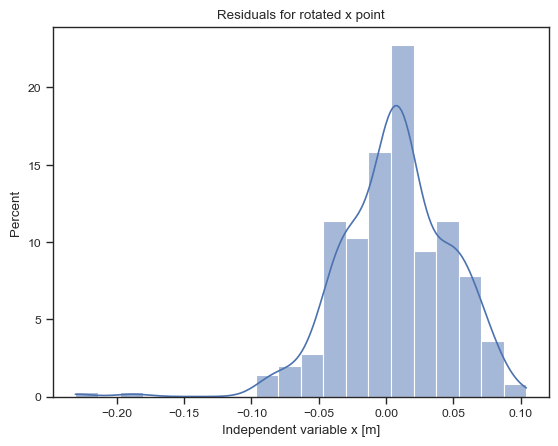

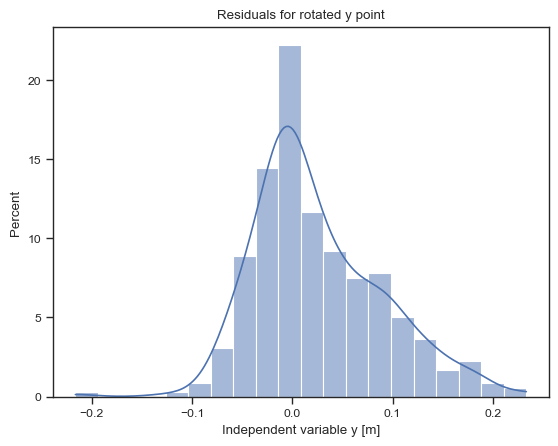

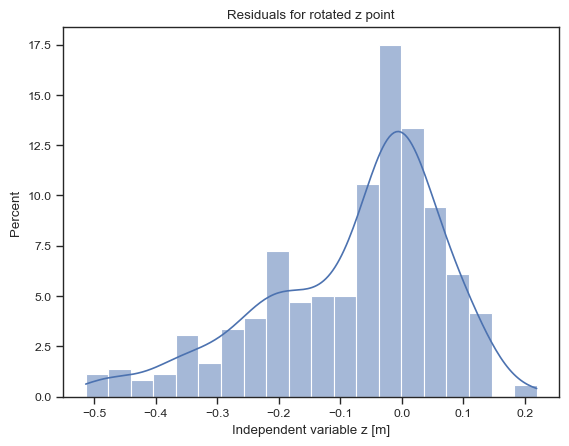

In [1638]:
for var in ['x', 'y', 'z']:
    g = sns.histplot(data=df_rotated_points_all, x='residual_' + var, kde=True, stat='percent', bins=20);
    # mean = df_rotated_points_all['residual_' + var].mean()
    # plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
    g.set_title('Residuals for rotated ' + var + ' point')
    g.set(xlabel='Independent variable ' + var + ' [m]')
    plt.show()

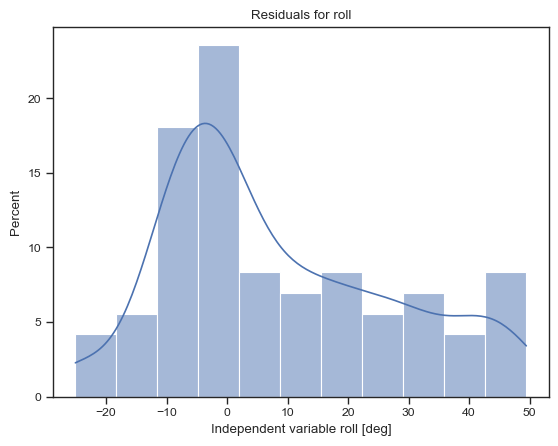

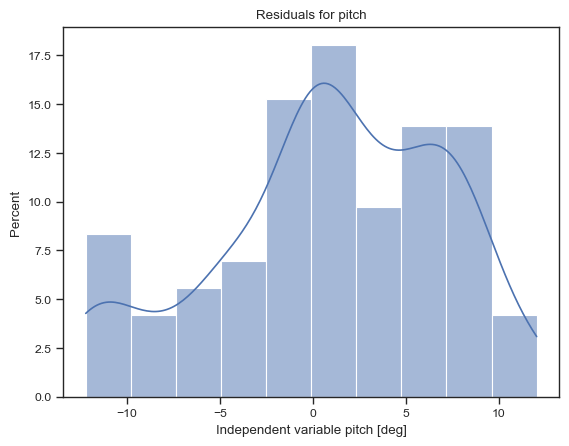

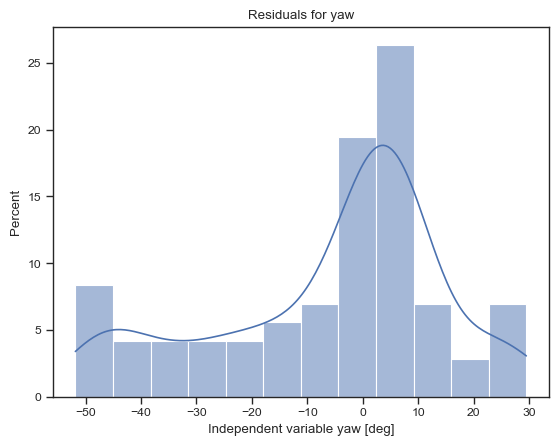

In [1639]:
for var in ['roll', 'pitch', 'yaw']:
    g = sns.histplot(data=df_rotated_points_all, x='residual_' + var, kde=True, stat='percent');
    g.set_title('Residuals for ' + var)
    g.set(xlabel='Independent variable ' + var + ' [deg]')
    plt.show()

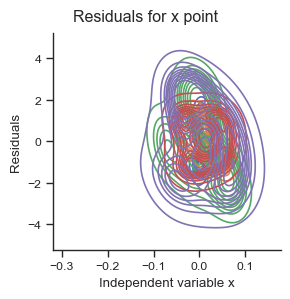

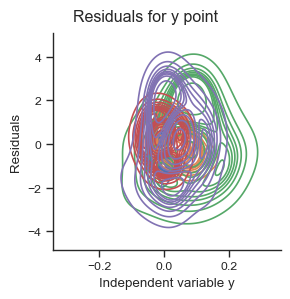

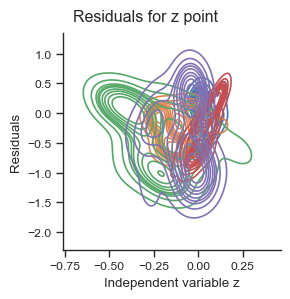

In [1648]:
for var in ['x', 'y', 'z']:
    g = sns.FacetGrid(df_rotated_points_all, col='3d_point', hue='3d_point', col_wrap=3).map(sns
                                                                                             .kdeplot,
                                                                                             'residual_' + var,
                                                                                             var + '_point_fine')
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Residuals for ' + var + ' point')
    for ax in g.axes.flat:
        ax.set(ylabel='Residuals', xlabel='Independent variable ' + var)

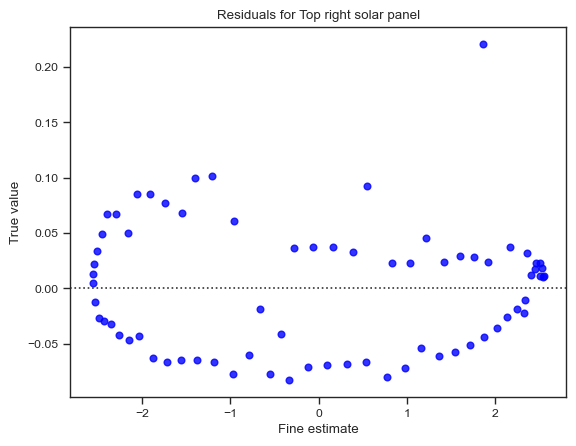

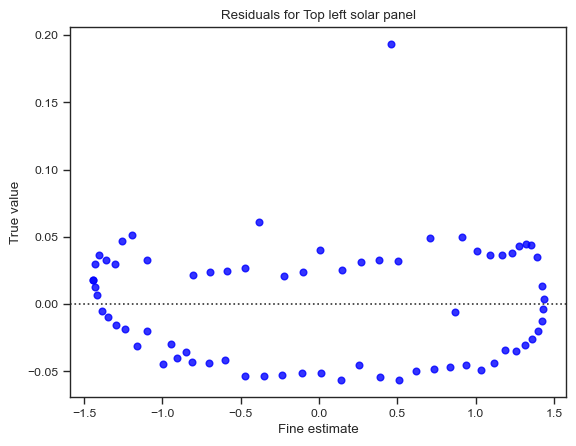

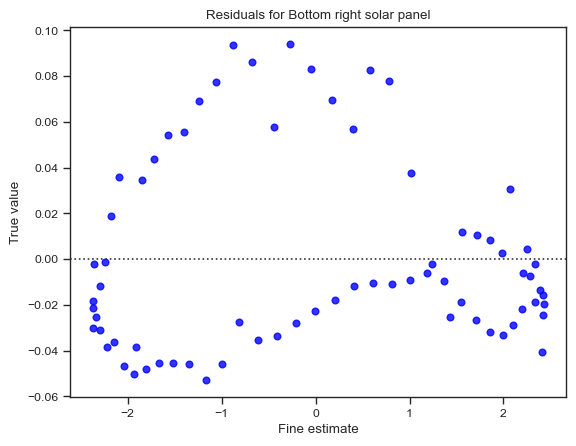

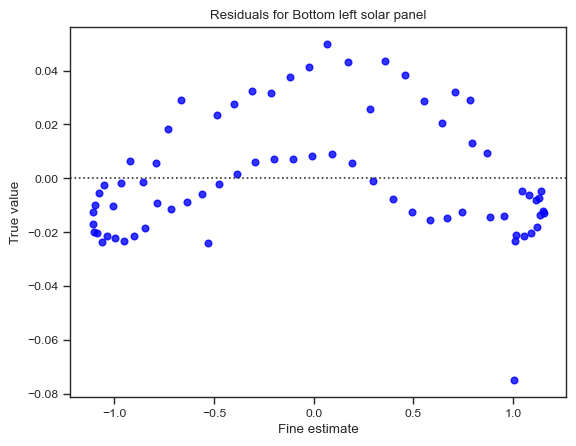

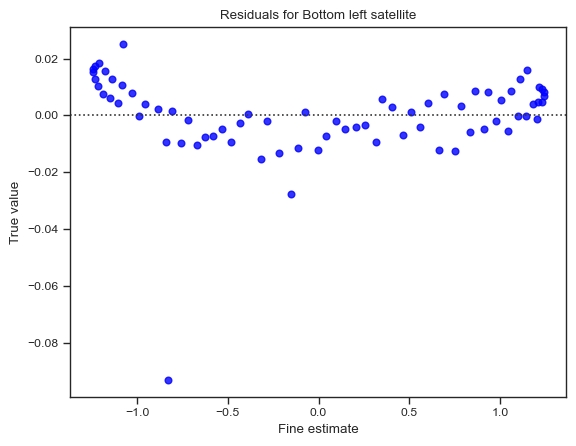

In [1641]:
for point in three_d_points_names:
    sns.residplot(data=df_rotated_points_all[df_rotated_points_all['3d_point'] == point], x='x_point_fine',
                  y='x_point_true', color='blue')
    plt.title("Residuals for " + point)
    plt.xlabel("Fine estimate")
    plt.ylabel("True value")
    plt.show()

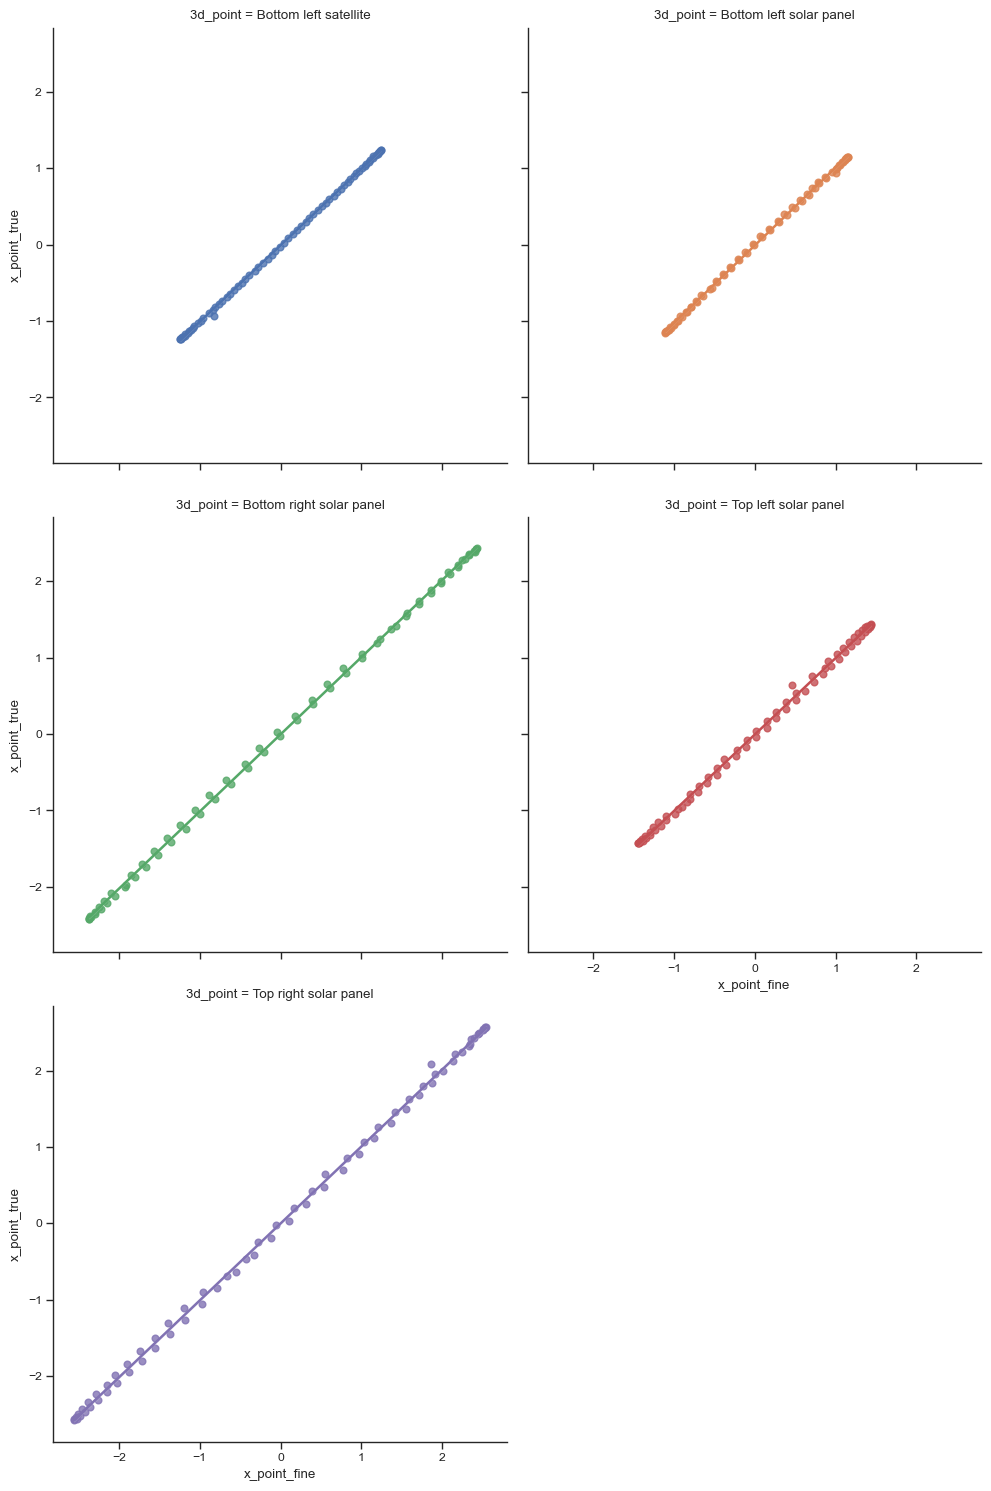

In [1642]:
sns.lmplot(data=df_rotated_points_all, x='x_point_fine', y='x_point_true', col='3d_point', hue='3d_point', col_wrap=2)

<Axes: xlabel='roll_fine', ylabel='roll_true'>

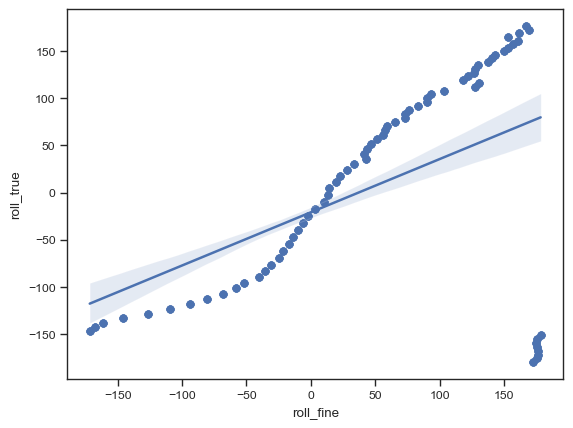

In [1643]:
sns.regplot(data=df_rotated_points_all, x='roll_fine', y='roll_true')

<Axes: xlabel='pitch_fine', ylabel='pitch_true'>

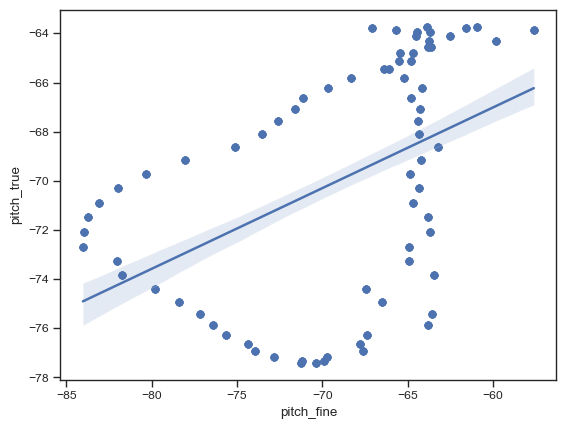

In [1644]:
sns.regplot(data=df_rotated_points_all, x='pitch_fine', y='pitch_true')

<Axes: xlabel='yaw_fine', ylabel='yaw_true'>

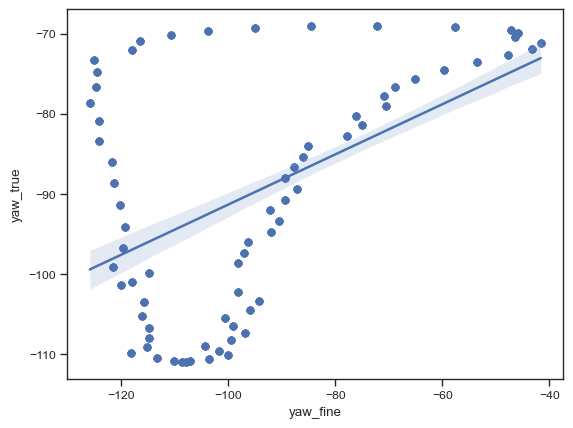

In [1645]:
sns.regplot(data=df_rotated_points_all, x='yaw_fine', y='yaw_true')